In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
from model import BuildingSimulation as bs, BuildingGraph as bg

plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
wallMaterial = {
    "key": "Material",
    "Name": "HW Wall",
    "Thickness": 0.1,
    "Conductivity": 0.8,
    "Density": 2300,
    "Specific_Heat": 750,
    "Thermal_Resistance": np.nan
}
wallMaterial = pd.DataFrame(wallMaterial, index = [0]).set_index('Name')

## Problem 1

In [20]:
sim_kwargs = {
    "delt": 15,
    "simLength": 96 * 60 * 60,
    "Tout" : 288.15,
    "radG": 400,
    "Tfloor": None,
}
wall_kwargs = {
    "X": 9,
    "Y": 10,
    "material_df": wallMaterial,
}

room_kwargs = {
    "T0": 293.15,
    "V" : 2880, #volume of air
    "Eint" : 250 #internal heat generation
}
vent_kwargs = {
    'H': 1,
    'W' : 1,
    "ventType": "HWP1",
    "alphas": None,
    "As": None,
    "Ls": None
}

connectivityMatrix = np.array([
    [3],
])

roomList = [
    ("R", {}), #room
    ]


              key  Thickness  Conductivity  Density  Specific_Heat  \
Name                                                                 
HW Wall  Material        0.1           0.8     2300            750   

         Thermal_Resistance  depth  
Name                                
HW Wall                 NaN    0.1  
maximum time step: 215.625


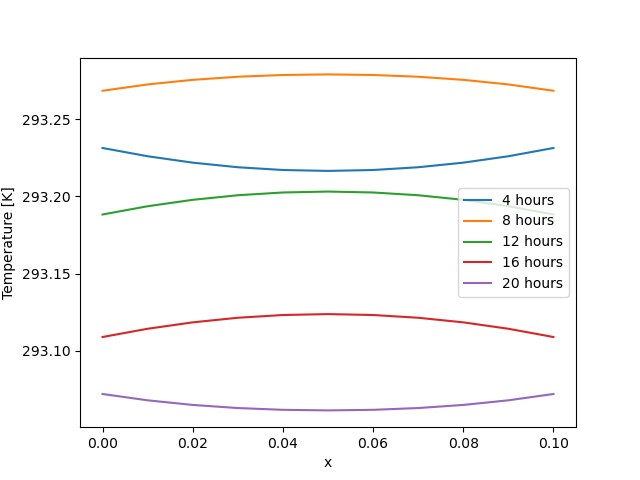

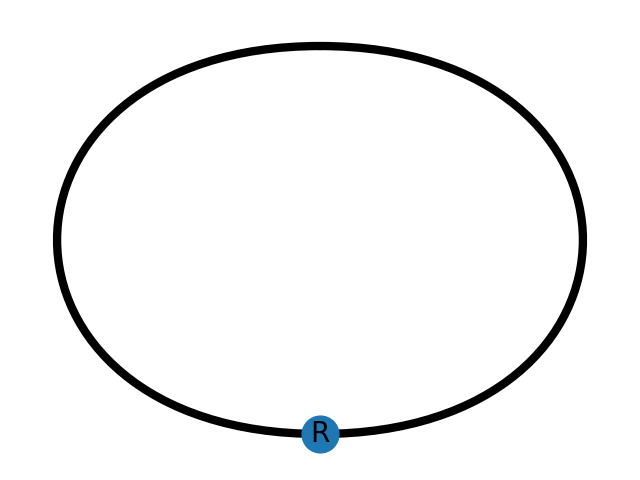

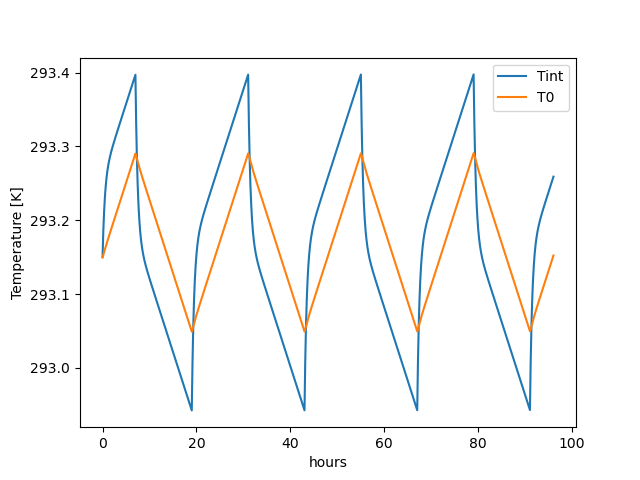

In [21]:
bG = bg.BuildingGraph(connectivityMatrix, roomList)
bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": bg.BuildingGraph()},
    })
bG.draw()

build_sim = bs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)

build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
T_profs = build_sim.bG.G.edges['R', 'R']['T_profs']
wall = build_sim.bG.G.edges['R', 'R']['wall']
h_profs = [4, 8, 12, 16, 20]
h_profs = [h + 48 for h in h_profs]
# h_profs = [0, *h_profs]

# Plotting
plt.figure()
plt.plot(build_sim.hours, Tints, label='Tint')
plt.plot(build_sim.hours, T_profs[0, :], label='T0')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

plt.figure()
for h in h_profs:
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(wall.x, T_profs[:, i], label=f'{h % 24} hours')

plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')
plt.show()

### Roof Instead of Walls


In [5]:
roomListOut = [
    ("R", {}), #room
    ("RF", {}),# outside
    ]

connectivityMatrixOut = np.array([
    [0 , 3],
    [3 , 0],
])



#### No Solar Radiation

              key  Thickness  Conductivity  Density  Specific_Heat  \
Name                                                                 
HW Wall  Material        0.1           0.8     2300            750   

         Thermal_Resistance  depth  
Name                                
HW Wall                 NaN    0.1  
maximum time step: 215.625


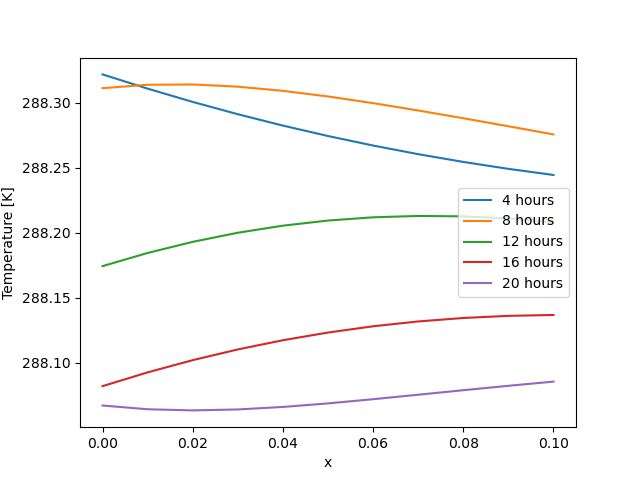

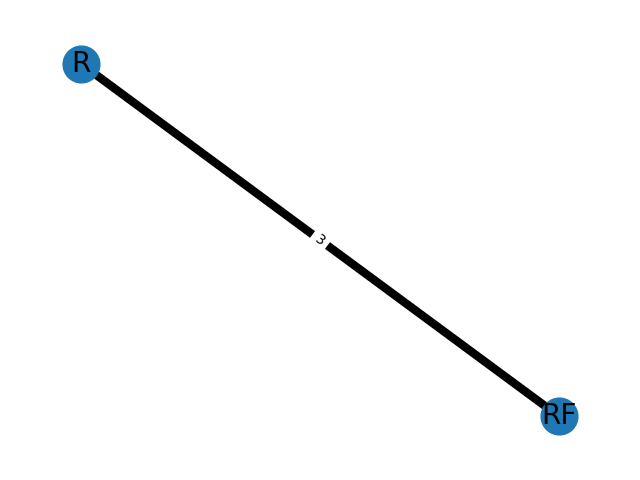

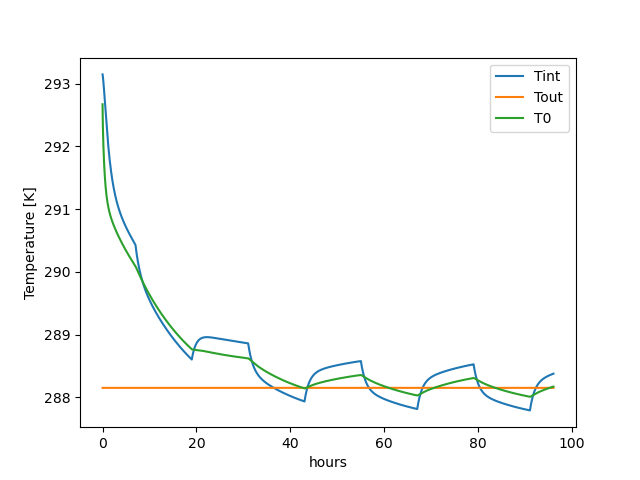

In [6]:
bG = bg.BuildingGraph(connectivityMatrixOut, roomListOut)
bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": bg.BuildingGraph()},
    })
bG.draw()


build_sim = bs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)

build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
Touts = build_sim.bG.G.nodes['RF']['Tints']
T_profs = build_sim.bG.G.edges['R', 'RF']['T_profs']
wall = build_sim.bG.G.edges['R', 'RF']['wall']


# Plotting
plt.figure()
plt.plot(build_sim.hours, Tints, label='Tint')
plt.plot(build_sim.hours, Touts, label='Tout')
plt.plot(build_sim.hours, T_profs[0, :], label='T0')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

plt.figure()
for h in h_profs:
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(wall.x, T_profs[:, i], label=f'{h % 24} hours')

plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')
plt.show()

#### Solar Radiation

              key  Thickness  Conductivity  Density  Specific_Heat  \
Name                                                                 
HW Wall  Material        0.1           0.8     2300            750   

         Thermal_Resistance  depth  
Name                                
HW Wall                 NaN    0.1  
maximum time step: 215.625


Text(0, 0.5, 'Radiation [W]')

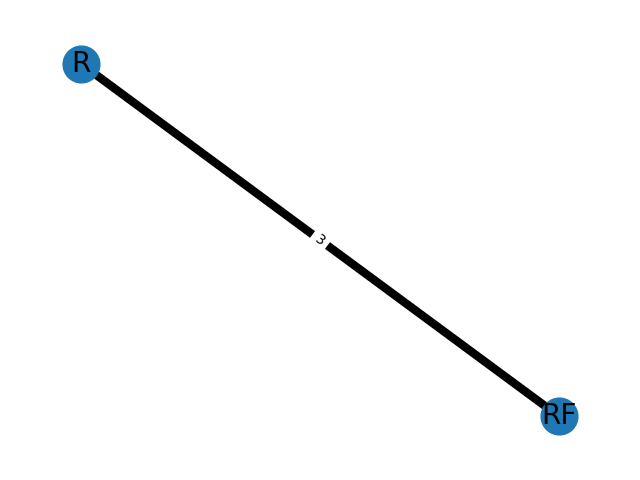

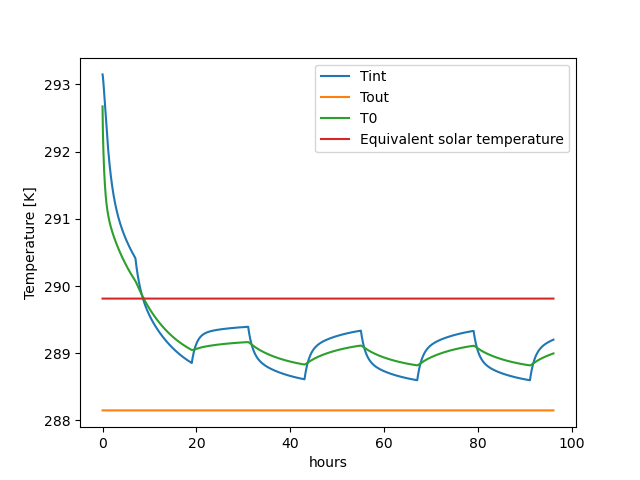

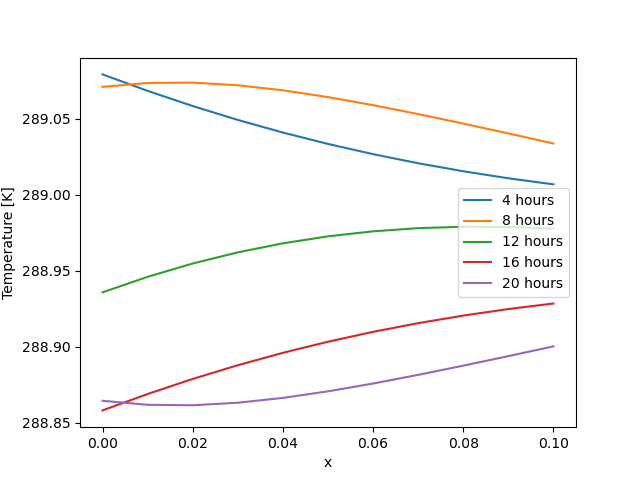

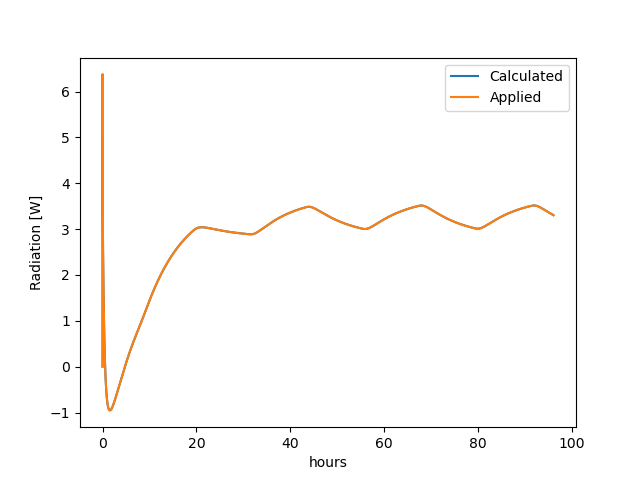

In [7]:
rad_kwargs_RF = {
    "bG": bg.BuildingGraph(
        np.array([
            [0, -1],
            [-1, 0],
        ]),
        [
            ("sun", {}), 
            ("R", {}),
        ]
    ),
}

bG = bg.BuildingGraph(connectivityMatrixOut, roomListOut)
bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": bg.BuildingGraph()},
    })
bG.updateNodes({"rad_kwargs": rad_kwargs_RF}, nodes=["RF"])
bG.draw()


build_sim = bs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)

build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
Touts = build_sim.bG.G.nodes['RF']['Tints']
T_profs = build_sim.bG.G.edges['R', 'RF']['T_profs']
wall = build_sim.bG.G.edges['R', 'RF']['wall']


# Plotting
plt.figure()
plt.plot(build_sim.hours, Tints, label='Tint')
plt.plot(build_sim.hours, Touts, label='Tout')
plt.plot(build_sim.hours, T_profs[0, :], label='T0')
plt.plot(build_sim.hours, (build_sim.radG/5.67e-8)**(1/4), label='Equivalent solar temperature')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

plt.figure()
for h in h_profs:
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(wall.x, T_profs[:, i], label=f'{h % 24} hours')

plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')

plt.figure()
plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radECalc"].back, label='Calculated')
plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radEApplied"].back, label='Applied')
plt.legend()
# plt.ylim([0, 25])
plt.xlabel('hours')
plt.ylabel('Radiation [W]')

## Problem 4

In [8]:
# Window dimmensions
H = 1
W = 1

# Load data
JW = sp.io.loadmat('JulyWeek.mat')
alphas = [42, 42, 42]
As = [1.61, 1.755, 1.755]
Ls = [11.34, 6.62, 2.07]

Q4 = sp.io.loadmat('./Q4data.mat')

Real_Tint = Q4['TintMeas'].flatten() + 273.15

T_start = Real_Tint[0]

hours = Q4['time'].flatten()
times = hours * 60 * 60
Tints[0] = T_start
Touts = Q4['Tout'].flatten() + 273.15

In [9]:
sim_kwargs = {
    "delt": times[1] - times[0],
    "simLength": times[-1] - times[0],
    "Tout" : Touts,
    "radG": 500,
    "Tfloor": None,
} 
wall_kwargs = {
    "X": 9,
    "Y": 10,
    "material_df": wallMaterial,
}

room_kwargs = {
    "T0": T_start,
    "V" : 2880, #volume of air
    "Eint" : 250 #internal heat generation
}

vent_kwargs = {
    'H': 1,
    'W' : 1,
    "ventType": "HWP4",
    "alphas": alphas,
    "As": As,
    "Ls": Ls,
}


              key  Thickness  Conductivity  Density  Specific_Heat  \
Name                                                                 
HW Wall  Material        0.1           0.8     2300            750   

         Thermal_Resistance  depth  
Name                                
HW Wall                 NaN    0.1  
maximum time step: 215.625


Text(0, 0.5, 'Temperature [K]')

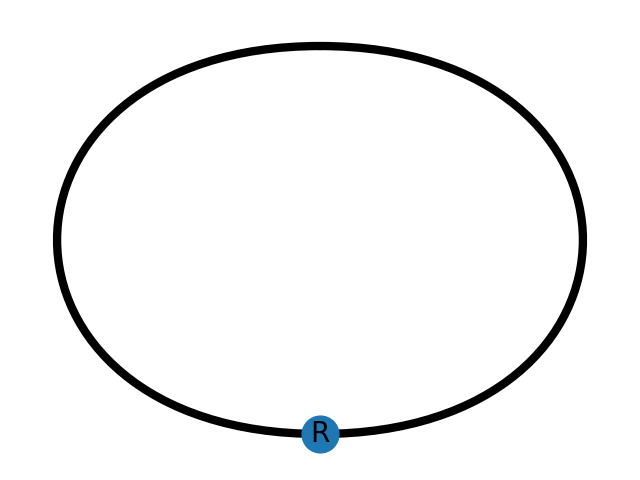

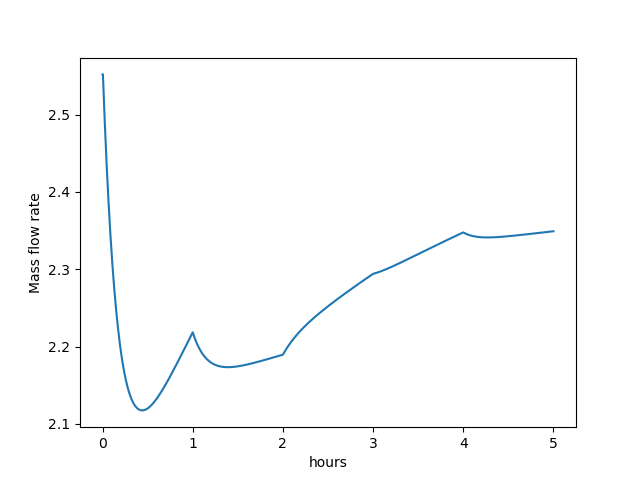

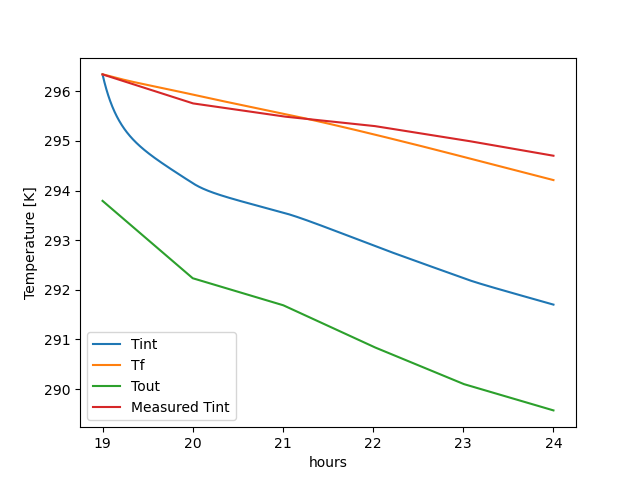

In [10]:

bG = bg.BuildingGraph(connectivityMatrix, roomList)
bG.draw()

bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": bg.BuildingGraph()},
    })

build_sim = bs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)
build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
T_profs = build_sim.bG.G.edges['R', 'R']['T_profs']
wall = build_sim.bG.G.edges['R', 'R']['wall']
Vnvs = build_sim.bG.G.nodes['R']['Vnvs']
Vnvs[0] = Vnvs[1]

# Plotting
plt.figure()
plt.plot(build_sim.hours, Vnvs)
plt.xlabel('hours')
plt.ylabel('Mass flow rate')

plt.figure()
plt.plot(hours, Tints, label='Tint')
plt.plot(hours, T_profs[0, :], label='Tf')
plt.plot(hours, Touts, label='Tout')
plt.plot(hours, Real_Tint, label='Measured Tint')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

### Roof Instead of Walls

#### No Solar Radiation

              key  Thickness  Conductivity  Density  Specific_Heat  \
Name                                                                 
HW Wall  Material        0.1           0.8     2300            750   

         Thermal_Resistance  depth  
Name                                
HW Wall                 NaN    0.1  
maximum time step: 215.625


Text(0, 0.5, 'Temperature [K]')

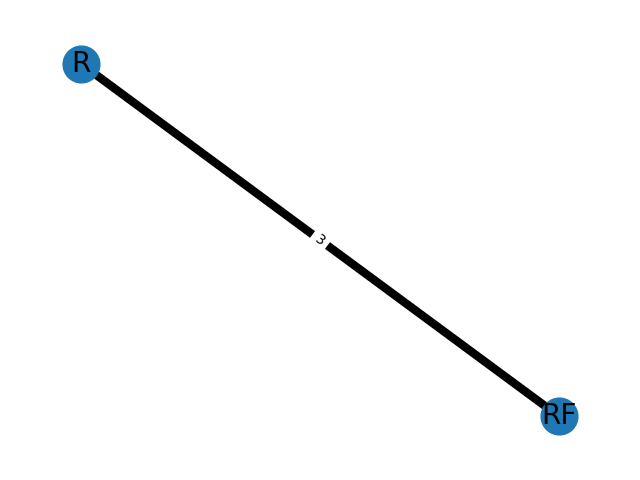

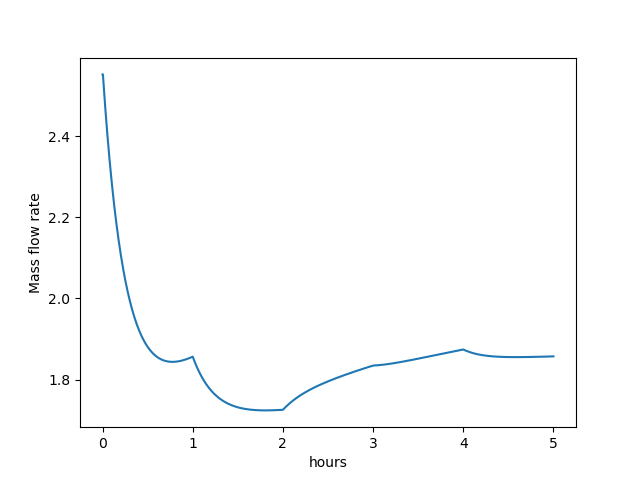

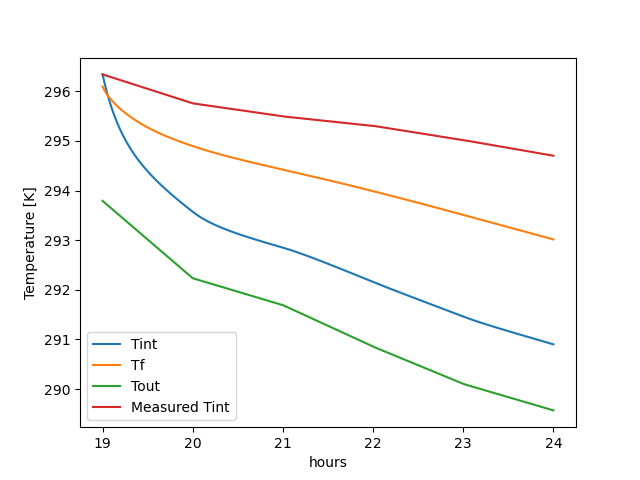

In [11]:

bG = bg.BuildingGraph(connectivityMatrixOut, roomListOut)
bG.draw()

bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": bg.BuildingGraph()},
    })

build_sim = bs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)
build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
T_profs = build_sim.bG.G.edges['R', 'RF']['T_profs']
wall = build_sim.bG.G.edges['R', 'RF']['wall']
Vnvs = build_sim.bG.G.nodes['R']['Vnvs']
Vnvs[0] = Vnvs[1]

# Plotting
plt.figure()
plt.plot(build_sim.hours, Vnvs)
plt.xlabel('hours')
plt.ylabel('Mass flow rate')

plt.figure()
plt.plot(hours, Tints, label='Tint')
plt.plot(hours, T_profs[0, :], label='Tf')
plt.plot(hours, Touts, label='Tout')
plt.plot(hours, Real_Tint, label='Measured Tint')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

#### Solar Radiation

              key  Thickness  Conductivity  Density  Specific_Heat  \
Name                                                                 
HW Wall  Material        0.1           0.8     2300            750   

         Thermal_Resistance  depth  
Name                                
HW Wall                 NaN    0.1  
maximum time step: 215.625


Text(0, 0.5, 'Radiation [W]')

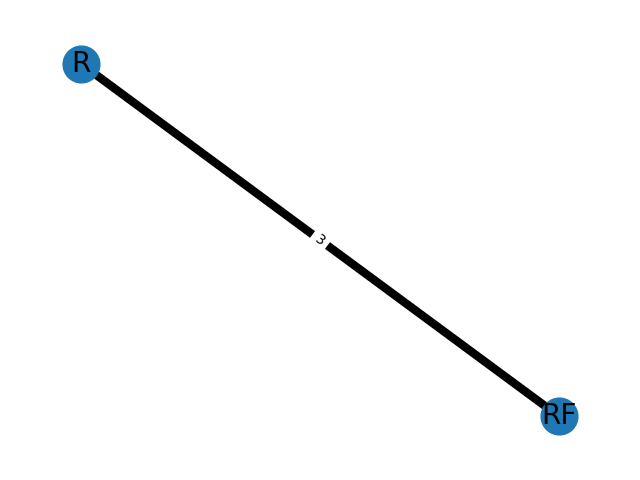

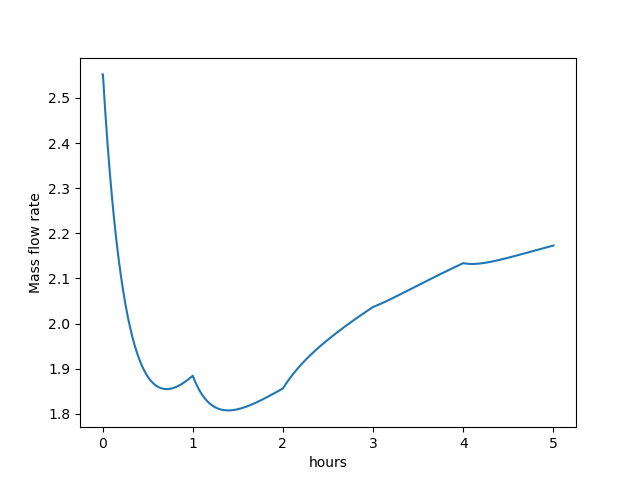

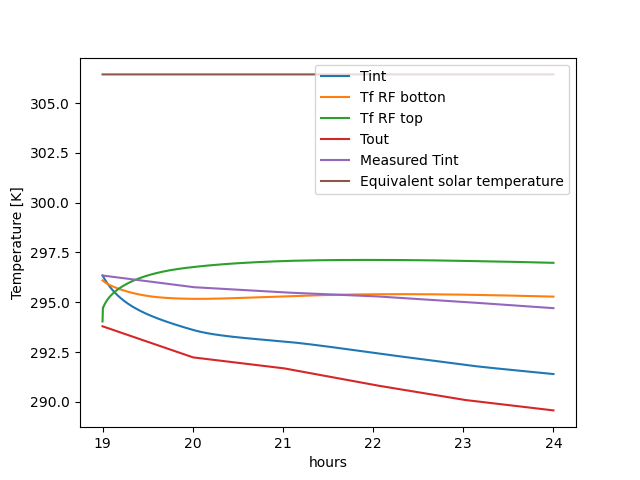

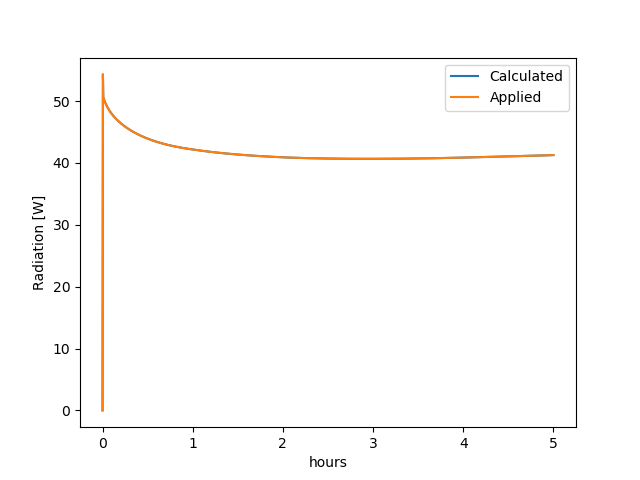

In [12]:

rad_kwargs_RF = {
    "bG": bg.BuildingGraph(
        np.array([
            [0, -1],
            [-1, 0],
        ]),
        [
            ("sun", {}), 
            ("R", {}),
        ]
    ),
}

bG = bg.BuildingGraph(connectivityMatrixOut, roomListOut)
bG.draw()

bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": bg.BuildingGraph()},
    })
bG.updateNodes({"rad_kwargs": rad_kwargs_RF}, nodes=["RF"])

build_sim = bs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)
build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
T_profs = build_sim.bG.G.edges['R', 'RF']['T_profs']
wall = build_sim.bG.G.edges['R', 'RF']['wall']
Vnvs = build_sim.bG.G.nodes['R']['Vnvs']
Vnvs[0] = Vnvs[1]

# Plotting
plt.figure()
plt.plot(build_sim.hours, Vnvs)
plt.xlabel('hours')
plt.ylabel('Mass flow rate')

plt.figure()
plt.plot(hours, Tints, label='Tint')
plt.plot(hours, T_profs[0, :], label='Tf RF botton')
plt.plot(hours, T_profs[-1, :], label='Tf RF top')
plt.plot(hours, Touts, label='Tout')
plt.plot(hours, Real_Tint, label='Measured Tint')
plt.plot(hours, (build_sim.radG/5.67e-8)**(1/4), label='Equivalent solar temperature')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

plt.figure()
plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radECalc"].back, label='Calculated')
plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radEApplied"].back, label='Applied')
plt.legend()
# plt.ylim([-200, 25])
plt.xlabel('hours')
plt.ylabel('Radiation [W]')

## Simple Multi-Room

/Users/nicholasbachand/Documents/Research/InteriorModeling/model/BuildingGraph.py:28: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



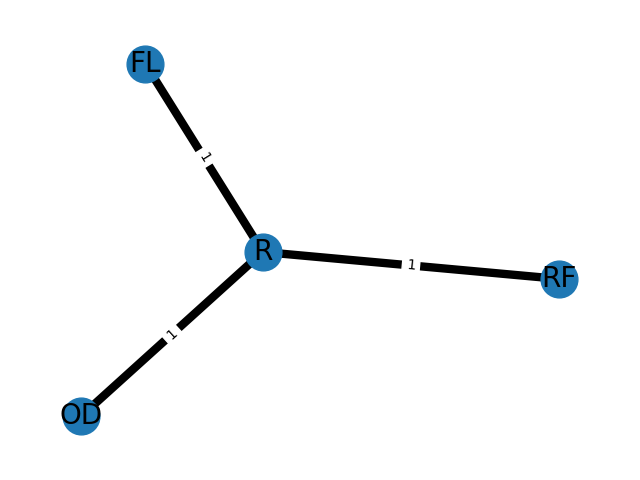

In [13]:
sim_kwargs["Tfloor"] = T_start

roomList = [
    ("R", {}), 
    ("FL", {}),
    ("RF", {}),
    ("OD", {}),
    ]

connectivityMatrix = np.array([
    [0, 1, 1, 1],
    [1, 0, 0 ,0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
])

bG = bg.BuildingGraph(connectivityMatrix, roomList)
bG.draw()

### No Radiation

              key  Thickness  Conductivity  Density  Specific_Heat  \
Name                                                                 
HW Wall  Material        0.1           0.8     2300            750   

         Thermal_Resistance  depth  
Name                                
HW Wall                 NaN    0.1  
maximum time step: 215.625


              key  Thickness  Conductivity  Density  Specific_Heat  \
Name                                                                 
HW Wall  Material        0.1           0.8     2300            750   

         Thermal_Resistance  depth  
Name                                
HW Wall                 NaN    0.1  
maximum time step: 215.625


              key  Thickness  Conductivity  Density  Specific_Heat  \
Name                                                                 
HW Wall  Material        0.1           0.8     2300            750   

         Thermal_Resistance  depth  
Name                                
HW Wall                 NaN    0.1  
maximum time step: 215.625


Text(0, 0.5, 'Temperature [K]')

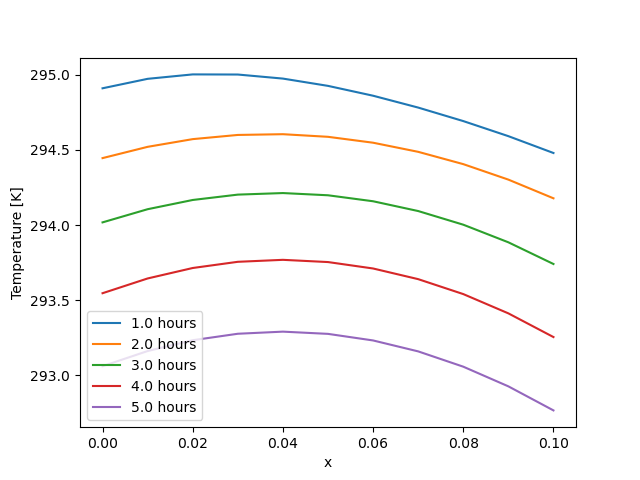

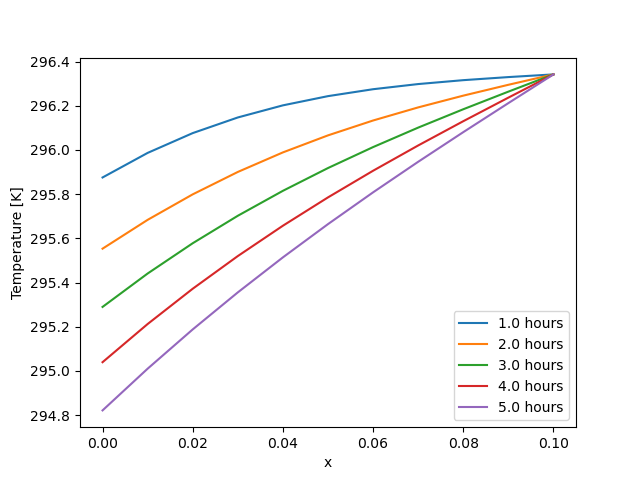

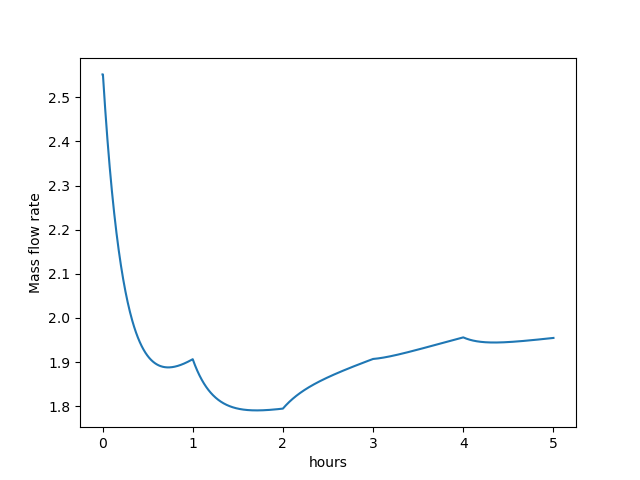

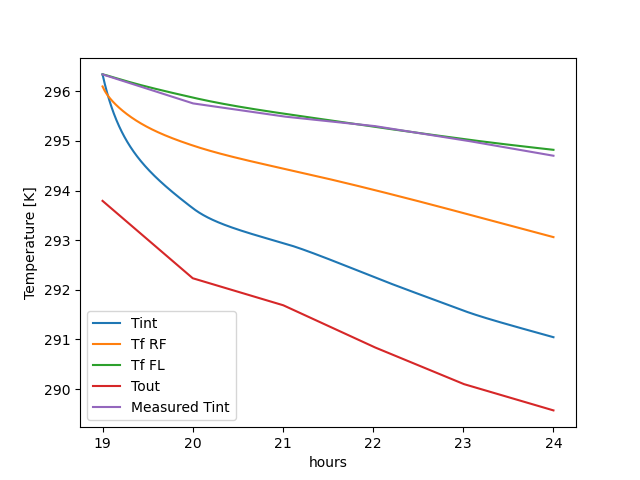

In [14]:
bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": bg.BuildingGraph()},
    })

build_sim = bs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)
build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
T_profs = build_sim.bG.G.edges['R', 'RF']['T_profs']
T_profs_FL = build_sim.bG.G.edges['R', 'FL']['T_profs']
floor = build_sim.bG.G.edges['R', 'FL']['wall']
Vnvs = build_sim.bG.G.nodes['R']['Vnvs']
Vnvs[0] = Vnvs[1]

# Plotting
plt.figure()
for h in h_profs:
    h = (h - 48)/4
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(wall.x, T_profs[:, i], label=f'{h % 24} hours')
plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')

plt.figure()
for h in h_profs:
    h = (h - 48)/4
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(floor.x, T_profs_FL[:, i], label=f'{h % 24} hours')
plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')


plt.figure()
plt.plot(build_sim.hours, Vnvs)
plt.xlabel('hours')
plt.ylabel('Mass flow rate')

plt.figure()
plt.plot(hours, Tints, label='Tint')
plt.plot(hours, T_profs[0, :], label='Tf RF')
plt.plot(hours, T_profs_FL[0, :], label='Tf FL')
plt.plot(hours, Touts, label='Tout')
plt.plot(hours, Real_Tint, label='Measured Tint')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

### Radiation

#### Internal Only

              key  Thickness  Conductivity  Density  Specific_Heat  \
Name                                                                 
HW Wall  Material        0.1           0.8     2300            750   

         Thermal_Resistance  depth  
Name                                
HW Wall                 NaN    0.1  
maximum time step: 215.625


              key  Thickness  Conductivity  Density  Specific_Heat  \
Name                                                                 
HW Wall  Material        0.1           0.8     2300            750   

         Thermal_Resistance  depth  
Name                                
HW Wall                 NaN    0.1  
maximum time step: 215.625


              key  Thickness  Conductivity  Density  Specific_Heat  \
Name                                                                 
HW Wall  Material        0.1           0.8     2300            750   

         Thermal_Resistance  depth  
Name                                
HW Wall                 NaN    0.1  
maximum time step: 215.625


Text(0, 0.5, 'Radiation [W]')

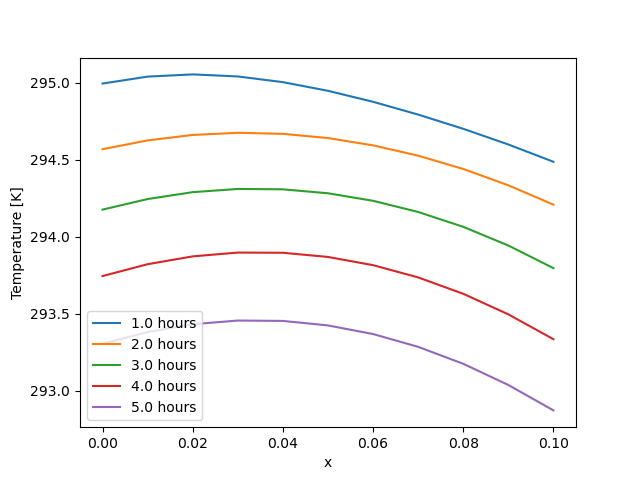

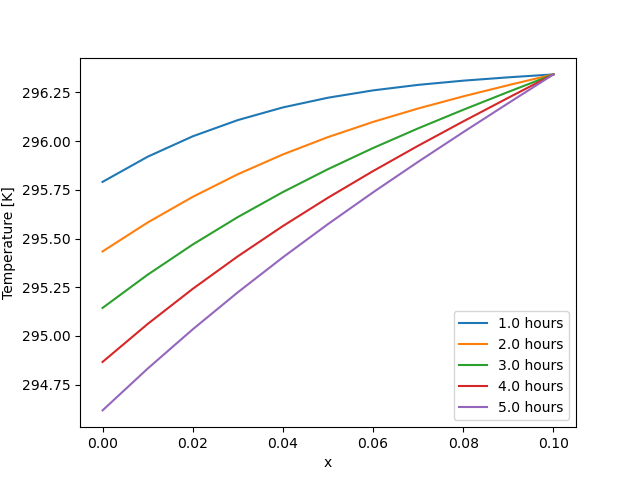

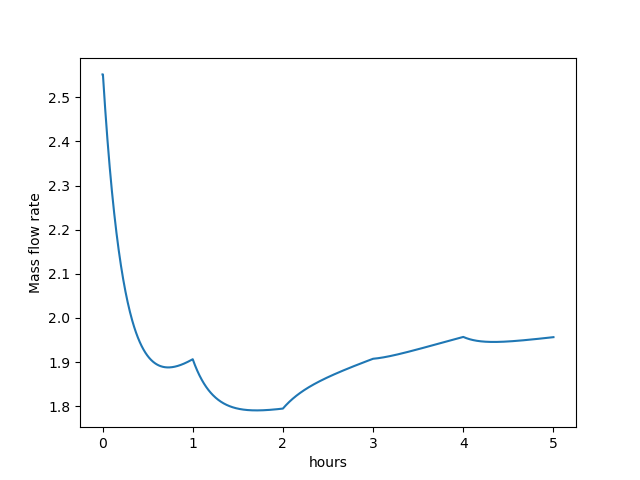

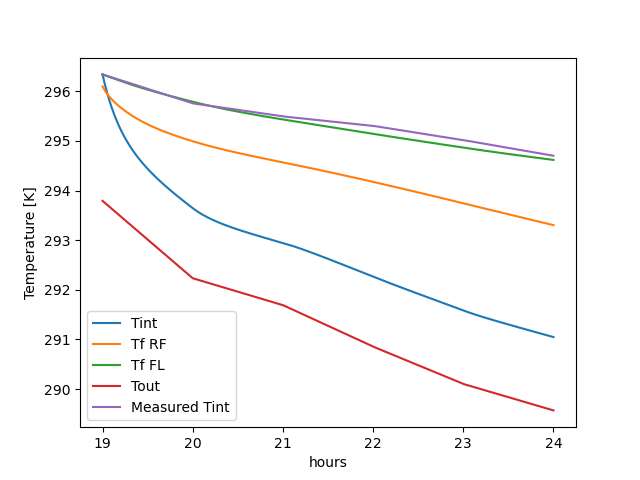

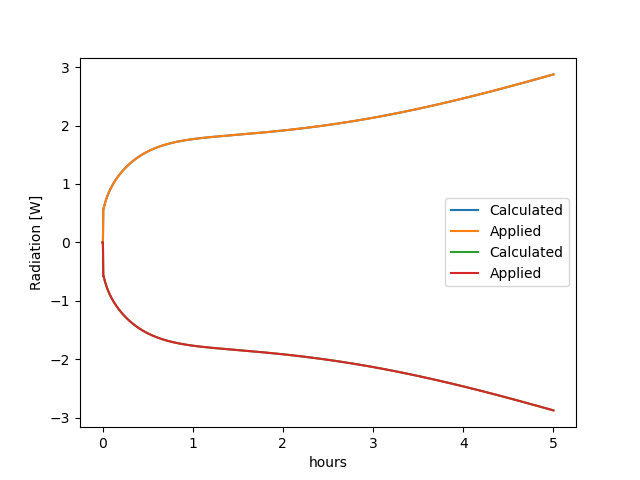

In [15]:
rad_kwargs_R = {
    "bG": bg.BuildingGraph(
        np.array([
            [0, 3],
            [3, 0],
        ]),
        [
            ("RF", {}), 
            ("FL", {}),
        ]
    ),
}

bG = bg.BuildingGraph(connectivityMatrix, roomList)
bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": bg.BuildingGraph()},
    })
bG.updateNodes({"rad_kwargs": rad_kwargs_R}, nodes=["R"])

build_sim = bs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)
build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
T_profs = build_sim.bG.G.edges['R', 'RF']['T_profs']
T_profs_FL = build_sim.bG.G.edges['R', 'FL']['T_profs']
floor = build_sim.bG.G.edges['R', 'FL']['wall']
Vnvs = build_sim.bG.G.nodes['R']['Vnvs']
Vnvs[0] = Vnvs[1]

# Plotting
plt.figure()
for h in h_profs:
    h = (h - 48)/4
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(wall.x, T_profs[:, i], label=f'{h % 24} hours')
plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')

plt.figure()
for h in h_profs:
    h = (h - 48)/4
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(floor.x, T_profs_FL[:, i], label=f'{h % 24} hours')
plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')


plt.figure()
plt.plot(build_sim.hours, Vnvs)
plt.xlabel('hours')
plt.ylabel('Mass flow rate')

plt.figure()
plt.plot(hours, Tints, label='Tint')
plt.plot(hours, T_profs[0, :], label='Tf RF')
plt.plot(hours, T_profs_FL[0, :], label='Tf FL')
plt.plot(hours, Touts, label='Tout')
plt.plot(hours, Real_Tint, label='Measured Tint')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

plt.figure()
plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radECalc"].front, label='Calculated')
plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radEApplied"].front, label='Applied')
plt.plot(build_sim.hours, build_sim.bG.G.edges[('FL', 'R')]["radECalc"].front, label='Calculated')
plt.plot(build_sim.hours, build_sim.bG.G.edges[('FL', 'R')]["radEApplied"].front, label='Applied')
plt.legend()
# plt.ylim([-200, 25])
plt.xlabel('hours')
plt.ylabel('Radiation [W]')

              key  Thickness  Conductivity  Density  Specific_Heat  \
Name                                                                 
HW Wall  Material        0.1           0.8     2300            750   

         Thermal_Resistance  depth  
Name                                
HW Wall                 NaN    0.1  
maximum time step: 215.625


              key  Thickness  Conductivity  Density  Specific_Heat  \
Name                                                                 
HW Wall  Material        0.1           0.8     2300            750   

         Thermal_Resistance  depth  
Name                                
HW Wall                 NaN    0.1  
maximum time step: 215.625


              key  Thickness  Conductivity  Density  Specific_Heat  \
Name                                                                 
HW Wall  Material        0.1           0.8     2300            750   

         Thermal_Resistance  depth  
Name                                
HW Wall                 NaN    0.1  
maximum time step: 215.625


Text(0, 0.5, 'Radiation [W]')

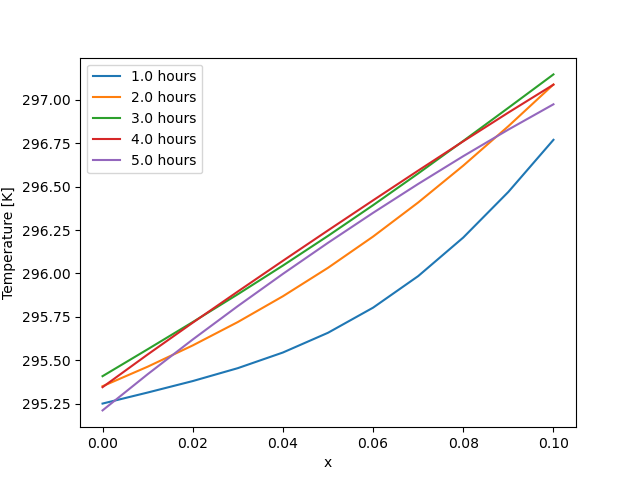

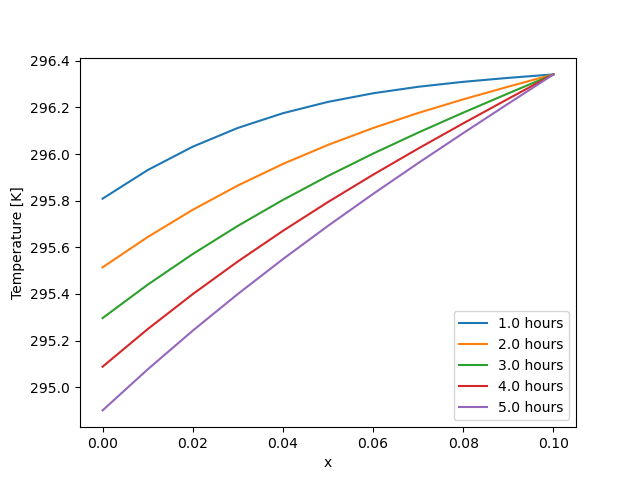

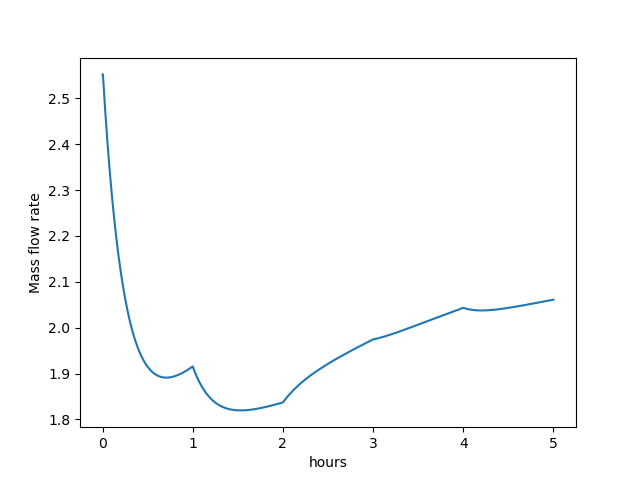

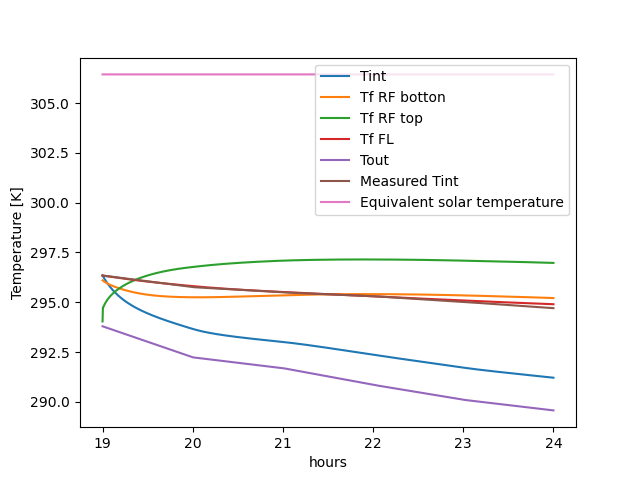

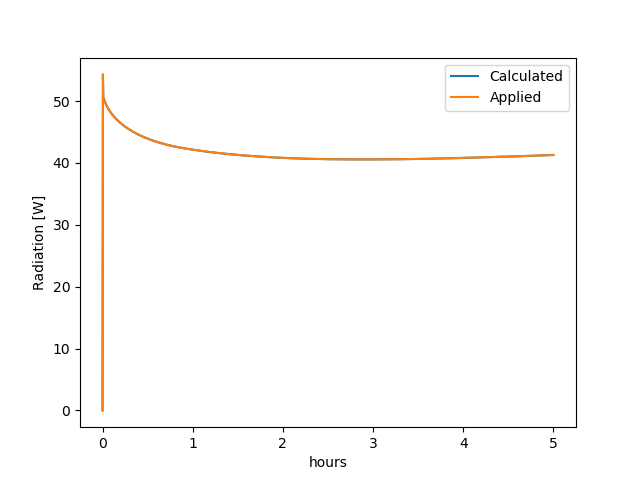

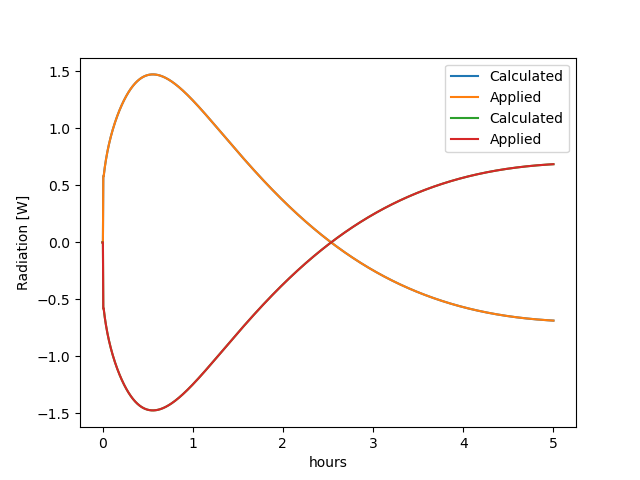

In [16]:
rad_kwargs_RF = {
    "bG": bg.BuildingGraph(
        np.array([
            [0, -1],
            [-1, 0],
        ]),
        [
            ("sun", {}), 
            ("R", {}),
        ]
    ),
}

bG = bg.BuildingGraph(connectivityMatrix, roomList)
bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": bg.BuildingGraph()},
    })
bG.updateNodes({"rad_kwargs": rad_kwargs_R}, nodes=["R"])
bG.updateNodes({"rad_kwargs": rad_kwargs_RF}, nodes=["RF"])

build_sim = bs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)
build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
T_profs = build_sim.bG.G.edges['R', 'RF']['T_profs']
T_profs_FL = build_sim.bG.G.edges['R', 'FL']['T_profs']
floor = build_sim.bG.G.edges['R', 'FL']['wall']
Vnvs = build_sim.bG.G.nodes['R']['Vnvs']
Vnvs[0] = Vnvs[1]

# Plotting
plt.figure()
for h in h_profs:
    h = (h - 48)/4
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(wall.x, T_profs[:, i], label=f'{h % 24} hours')
plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')

plt.figure()
for h in h_profs:
    h = (h - 48)/4
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(floor.x, T_profs_FL[:, i], label=f'{h % 24} hours')
plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')

plt.figure()
plt.plot(build_sim.hours, Vnvs)
plt.xlabel('hours')
plt.ylabel('Mass flow rate')

plt.figure()
plt.plot(hours, Tints, label='Tint')
plt.plot(hours, T_profs[0, :], label='Tf RF botton')
plt.plot(hours, T_profs[-1, :], label='Tf RF top')
plt.plot(hours, T_profs_FL[0, :], label='Tf FL')
plt.plot(hours, Touts, label='Tout')
plt.plot(hours, Real_Tint, label='Measured Tint')
plt.plot(hours, (build_sim.radG/5.67e-8)**(1/4), label='Equivalent solar temperature')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

plt.figure()
plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radECalc"].back, label='Calculated')
plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radEApplied"].back, label='Applied')
plt.legend()
# plt.ylim([-200, 25])
plt.xlabel('hours')
plt.ylabel('Radiation [W]')

plt.figure()
plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radECalc"].front, label='Calculated')
plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radEApplied"].front, label='Applied')
plt.plot(build_sim.hours, build_sim.bG.G.edges[('FL', 'R')]["radECalc"].front, label='Calculated')
plt.plot(build_sim.hours, build_sim.bG.G.edges[('FL', 'R')]["radEApplied"].front, label='Applied')
plt.legend()
# plt.ylim([-200, 25])
plt.xlabel('hours')
plt.ylabel('Radiation [W]')


#### No Ventilation

              key  Thickness  Conductivity  Density  Specific_Heat  \
Name                                                                 
HW Wall  Material        0.1           0.8     2300            750   

         Thermal_Resistance  depth  
Name                                
HW Wall                 NaN    0.1  
maximum time step: 215.625


              key  Thickness  Conductivity  Density  Specific_Heat  \
Name                                                                 
HW Wall  Material        0.1           0.8     2300            750   

         Thermal_Resistance  depth  
Name                                
HW Wall                 NaN    0.1  
maximum time step: 215.625


              key  Thickness  Conductivity  Density  Specific_Heat  \
Name                                                                 
HW Wall  Material        0.1           0.8     2300            750   

         Thermal_Resistance  depth  
Name                                
HW Wall                 NaN    0.1  
maximum time step: 215.625


Text(0, 0.5, 'Radiation [W]')

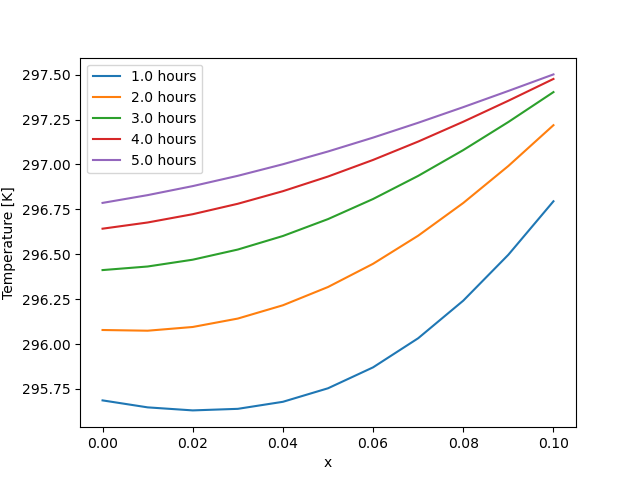

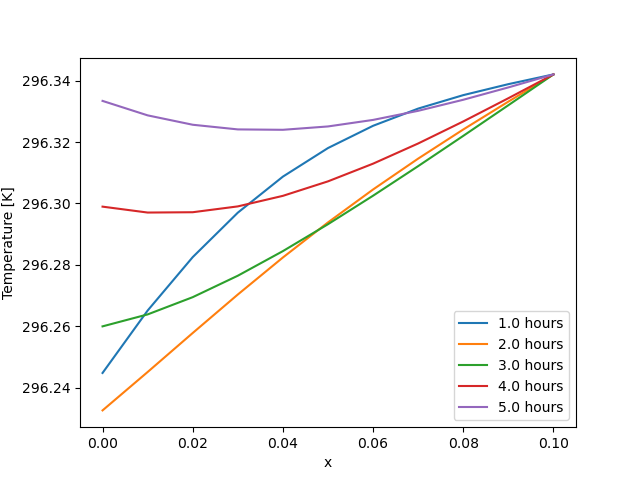

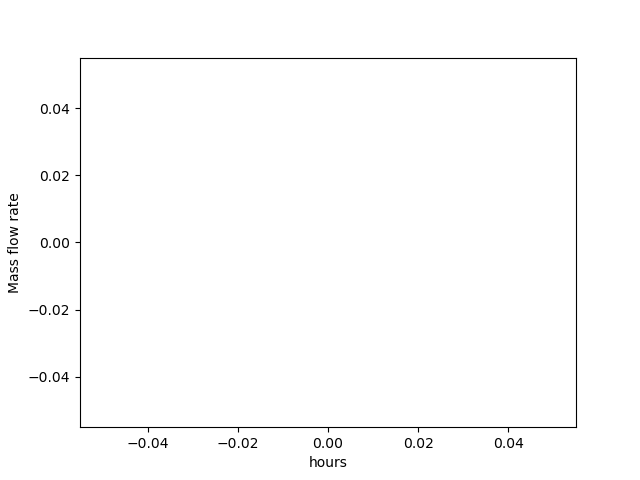

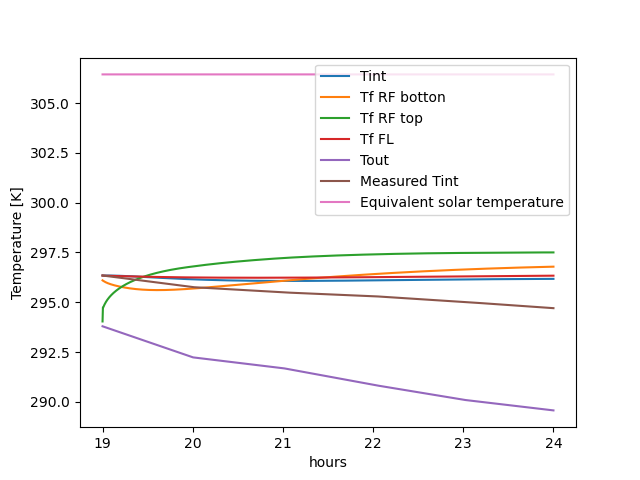

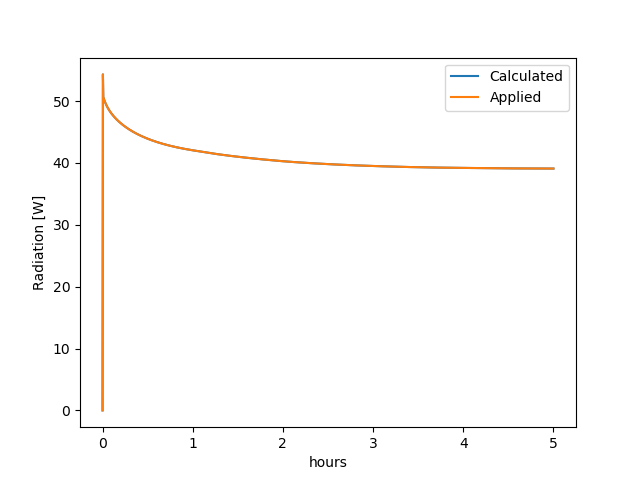

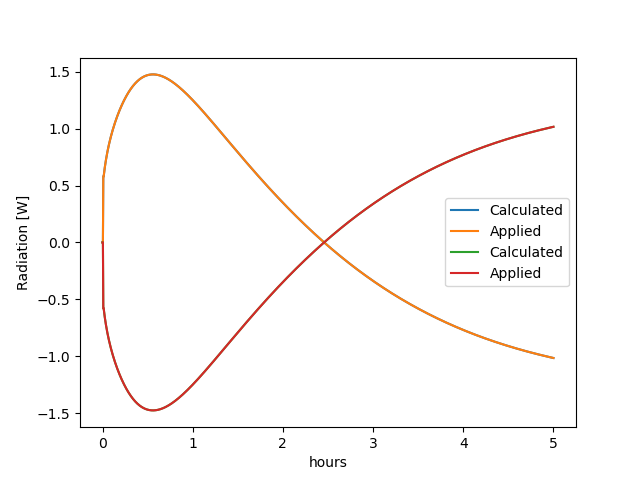

In [17]:
vent_kwargs["ventType"] = None
bG = bg.BuildingGraph(connectivityMatrix, roomList)
bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": bg.BuildingGraph()},
    })
bG.updateNodes({"rad_kwargs": rad_kwargs_R}, nodes=["R"])
bG.updateNodes({"rad_kwargs": rad_kwargs_RF}, nodes=["RF"])

build_sim = bs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)
build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
T_profs = build_sim.bG.G.edges['R', 'RF']['T_profs']
T_profs_FL = build_sim.bG.G.edges['R', 'FL']['T_profs']
floor = build_sim.bG.G.edges['R', 'FL']['wall']
Vnvs = build_sim.bG.G.nodes['R']['Vnvs']
Vnvs[0] = Vnvs[1]

# Plotting
plt.figure()
for h in h_profs:
    h = (h - 48)/4
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(wall.x, T_profs[:, i], label=f'{h % 24} hours')
plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')

plt.figure()
for h in h_profs:
    h = (h - 48)/4
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(floor.x, T_profs_FL[:, i], label=f'{h % 24} hours')
plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')

plt.figure()
plt.plot(build_sim.hours, Vnvs)
plt.xlabel('hours')
plt.ylabel('Mass flow rate')

plt.figure()
plt.plot(hours, Tints, label='Tint')
plt.plot(hours, T_profs[0, :], label='Tf RF botton')
plt.plot(hours, T_profs[-1, :], label='Tf RF top')
plt.plot(hours, T_profs_FL[0, :], label='Tf FL')
plt.plot(hours, Touts, label='Tout')
plt.plot(hours, Real_Tint, label='Measured Tint')
plt.plot(hours, (build_sim.radG/5.67e-8)**(1/4), label='Equivalent solar temperature')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

plt.figure()
plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radECalc"].back, label='Calculated')
plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radEApplied"].back, label='Applied')
plt.legend()
# plt.ylim([-200, 25])
plt.xlabel('hours')
plt.ylabel('Radiation [W]')

plt.figure()
plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radECalc"].front, label='Calculated')
plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radEApplied"].front, label='Applied')
plt.plot(build_sim.hours, build_sim.bG.G.edges[('FL', 'R')]["radECalc"].front, label='Calculated')
plt.plot(build_sim.hours, build_sim.bG.G.edges[('FL', 'R')]["radEApplied"].front, label='Applied')
plt.legend()
# plt.ylim([-200, 25])
plt.xlabel('hours')
plt.ylabel('Radiation [W]')
